In [ ]:
!pip  install  ultralytics
from ultralytics import YOLO

# Mount Google Drive Account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup File Structure
```
datasets/
└── torso/ <-- (class label)
    ├── images/
    │   ├── train/
    │   └── val/
    ├── labels/
    │   ├── train/
    │   └── val/
    └── torso.yaml
```

In [ ]:
import os
import yaml

def setup_yolo_pose_dataset(base_path="dataset/torso",
                            num_keypoints=4,
                            class_name="torso",
                            keypoint_order=["left shoulder", "right shoulder", "left hip", "right hip"]):
    """
    Creates a folder structure and a dataset YAML config for YOLOv8 pose training.
    """
    # Folder structure
    image_train = os.path.join(base_path, "images/train")
    image_val = os.path.join(base_path, "images/val")
    label_train = os.path.join(base_path, "labels/train")
    label_val = os.path.join(base_path, "labels/val")

    os.makedirs(image_train, exist_ok=True)
    os.makedirs(image_val, exist_ok=True)
    os.makedirs(label_train, exist_ok=True)
    os.makedirs(label_val, exist_ok=True)

    # Build dataset YAML
    class_dict = {0: class_name}

    def infer_flip_idx(kp_order):
        # auto-generate flip_idx assuming left/right naming
        flip = []
        for i, kp in enumerate(kp_order):
            if "left" in kp:
                try: flip.append(kp_order.index(kp.replace("left", "right")))
                except: flip.append(i)
            elif "right" in kp:
                try: flip.append(kp_order.index(kp.replace("right", "left")))
                except: flip.append(i)
            else:
                flip.append(i)
        return flip

    flip_idx = infer_flip_idx(keypoint_order)

    """
    yaml reference: https://docs.ultralytics.com/tasks/pose/#train

    # Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
    path: ../datasets/coco8-pose # dataset root dir (absolute or relative; if relative, it's relative to default datasets_dir)
    train: images/train # train images (relative to 'path') 4 images
    val: images/val # val images (relative to 'path') 4 images
    test: # test images (optional)

    # Keypoints
    kpt_shape: [17, 3] # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)
    flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]

    # Classes dictionary
    names:
        0: person

    """

    # Define inline list wrapper
    class InlineList(list): pass
    def represent_inline_list(dumper, data):
        return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)
    yaml.add_representer(InlineList, represent_inline_list)

    # Construct inline-style YAML dictionary
    yaml_dict = {
        "path": base_path,
        "train": "images/train",
        "val": "images/val",
        "kpt_shape": InlineList([num_keypoints, 3]),
        "flip_idx": InlineList(flip_idx),
        "names": class_dict
    }

    yaml_path = os.path.join(base_path, "torso.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_dict, f, sort_keys=False)

    print(f"✅ Dataset folder and YAML created at: {base_path}")
    print(f"🧾 YAML config: {yaml_path}")


In [ ]:
setup_yolo_pose_dataset()

✅ Dataset folder and YAML created at: dataset/torso
🧾 YAML config: dataset/torso/torso.yaml


# Split images into train/val

In [ ]:
import random
import shutil

def split_and_copy_images(image_folder, dest_image_folder, val_ratio=0.2):
    all_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(all_images)

    split_idx = int(len(all_images) * (1 - val_ratio))
    train_imgs = all_images[:split_idx]
    val_imgs = all_images[split_idx:]

    for f in train_imgs:
        shutil.copy(os.path.join(image_folder, f), os.path.join(dest_image_folder, "train", f))
    for f in val_imgs:
        shutil.copy(os.path.join(image_folder, f), os.path.join(dest_image_folder, "val", f))

    return train_imgs, val_imgs

# Convert CSV annotation format to Yolov8 for pose estimation

(Label images with [left shoulder, right shoulder, left hip, right hip]. Note that left and right are with respective to the mannequin not the viewer)

In [ ]:
import pandas as pd
from collections import defaultdict

def convert_makesense_csv_to_yolo_labels(csv_path, output_dir, image_list, keypoint_order):
    df = pd.read_csv(csv_path, header=None)
    df.columns = ["keypoint", "x", "y", "filename", "img_width", "img_height"]

    ordered_kps = keypoint_order
    grouped = defaultdict(list)

    for _, row in df.iterrows():
        fname = row["filename"]
        if fname not in image_list:
            continue
        kp_label = row["keypoint"].strip().lower()
        grouped[fname].append({
            "keypoint": kp_label,
            "x": row["x"] / row["img_width"],
            "y": row["y"] / row["img_height"],
            "vis": 2
        })

    os.makedirs(output_dir, exist_ok=True)
    for filename, kps in grouped.items():
        kp_dict = {kp["keypoint"]: kp for kp in kps}
        if not all(k in kp_dict for k in ordered_kps):
            continue

        keypoints_flat = []
        x_vals, y_vals = [], []
        for k in ordered_kps:
            kp = kp_dict[k]
            keypoints_flat.extend([kp["x"], kp["y"], kp["vis"]])
            x_vals.append(kp["x"])
            y_vals.append(kp["y"])

        x_center = (min(x_vals) + max(x_vals)) / 2
        y_center = (min(y_vals) + max(y_vals)) / 2
        bbox_w = max(x_vals) - min(x_vals)
        bbox_h = max(y_vals) - min(y_vals)

        label_line = f"0 {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f} " + \
                     " ".join(f"{v:.6f}" if i % 3 != 2 else f"{int(v)}"
                              for i, v in enumerate(keypoints_flat))

        label_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".txt")
        with open(label_path, "w") as f:
            f.write(label_line + "\n")


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os


# To make sure annotation is as expected
import cv2
import matplotlib.pyplot as plt
import os

def visualize_yolo_pose_annotation(base_path, split="train", image_filename="frame_00001.png"):
    """
    Visualizes a YOLOv8 pose annotation (bounding box + keypoints + labels) on one image.

    Args:
        base_path (str): Path to the dataset root (e.g. /content/datasets/torso)
        split (str): "train" or "val"
        image_filename (str): image filename (e.g. "frame_00001.png")
    """
    image_path = os.path.join(base_path, "images", split, image_filename)
    label_path = os.path.join(base_path, "labels", split, os.path.splitext(image_filename)[0] + ".txt")

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Image not found: {image_path}")
        return

    h, w = image.shape[:2]

    # Read label file
    with open(label_path, "r") as f:
        line = f.readline().strip().split()
        class_id = int(line[0])
        x_center, y_center, box_w, box_h = map(float, line[1:5])
        keypoints = list(map(float, line[5:]))

    # Draw bounding box
    x1 = int((x_center - box_w / 2) * w)
    y1 = int((y_center - box_h / 2) * h)
    x2 = int((x_center + box_w / 2) * w)
    y2 = int((y_center + box_h / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Define keypoint labels
    kp_labels = ["left shoulder", "right shoulder", "left hip", "right hip"]

    # Draw keypoints and labels
    for i in range(4):
        x = int(keypoints[i * 3] * w)
        y = int(keypoints[i * 3 + 1] * h)
        vis = int(keypoints[i * 3 + 2])
        if vis > 0:
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            cv2.putText(image, kp_labels[i], (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Display in Colab
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_filename)
    plt.show()


In [ ]:
import os

path = "/content/drive/MyDrive/67930/testing_random_frames.csv"

if os.path.exists(path):
    print("✅ Path exists!")
else:
    print("❌ Path does not exist!")

❌ Path does not exist!


In [ ]:
base_path = "/content/test_dataset/torso"
image_folder = "/content/test_imgs" # Folder with annotated images
csv_path = "/content/test_imgs_annotations.csv" # CSV annotations of images from makesense.ai
keypoint_order = ["left shoulder", "right shoulder", "left hip", "right hip"]

# Step 1: Set up folders + YAML
setup_yolo_pose_dataset(
    base_path,
    num_keypoints=4,
    class_name="torso",
    keypoint_order=keypoint_order
)

# Step 2: Copy and split images
train_imgs, val_imgs = split_and_copy_images(image_folder, os.path.join(base_path, "images"))

# Step 3: Convert CSV to YOLO labels for each split (train and val) and put in respectively folder
convert_makesense_csv_to_yolo_labels(csv_path, os.path.join(base_path, "labels/train"), train_imgs, keypoint_order)
convert_makesense_csv_to_yolo_labels(csv_path, os.path.join(base_path, "labels/val"), val_imgs, keypoint_order)


✅ Dataset folder and YAML created at: /content/test_dataset/torso
🧾 YAML config: /content/test_dataset/torso/torso.yaml


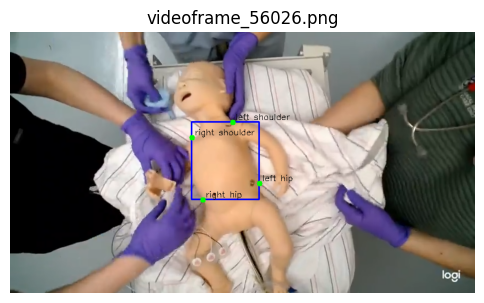

In [ ]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="videoframe_56026.png"
)

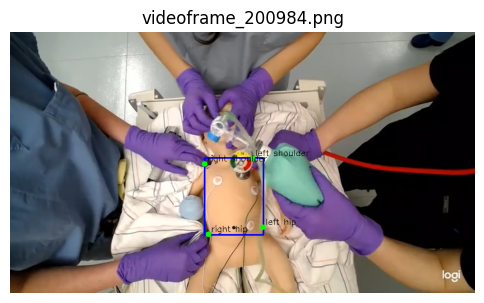

In [ ]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="videoframe_200984.png"
)



---






# Model Weights/Initialization

In [ ]:
model = YOLO('yolov8n-pose.pt');

# Model Training

In [ ]:
yaml_path = os.path.join(base_path, "torso.yaml")

# === Training Hyperparameters ===
EPOCH_NUM = 25
IMG_SIZE = 640               # All images resized to 640x640 during training/inference
BATCH_SIZE = 4
DEVICE = "cpu"                 # GPU 0 (use "cpu" if no GPU)
INIT_LR = 0.001
OPTIMIZER = "AdamW"
RUN_NAME = "torso_pose"
PROJECT_DIR = "/content/torso"

# === Run Training ===
model.train(
    data=yaml_path,
    epochs=EPOCH_NUM,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    lr0=INIT_LR,
    optimizer=OPTIMIZER,
    name=RUN_NAME,
    project=PROJECT_DIR,
)


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/test_dataset/torso/torso.yaml, epochs=25, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=/content/torso, name=torso_pose2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /content/test_dataset/torso/labels/train... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 530.71it/s]

train: New cache created: /content/test_dataset/torso/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/test_dataset/torso/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 800.17it/s]

val: New cache created: /content/test_dataset/torso/labels/val.cache


Plotting labels to /content/torso/torso_pose2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/torso/torso_pose2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      2.932      6.326     0.6214      6.299      3.044          6        640: 100%|██████████| 4/4 [00:20<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          4          4   0.000833       0.25   0.000609   0.000183     0.0283       0.25     0.0207    0.00622



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      2.854      4.101     0.4965      3.141       2.64         14        640: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          4          4    0.00333          1     0.0104     0.0045    0.00104       0.25     0.0145    0.00145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      2.128      3.138     0.4985      2.715      2.146          8        640: 100%|██████████| 4/4 [00:20<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all          4          4    0.00668        0.5     0.0205    0.00714    0.00411       0.75     0.0113    0.00142



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      2.066      2.849     0.4297       2.73      2.368          7        640: 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4          4     0.0245       0.25     0.0422     0.0096     0.0355       0.25     0.0566     0.0134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.899      3.194     0.4904      2.415      2.107          9        640: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          4          4     0.0499          1     0.0529     0.0186      0.117        0.5      0.167     0.0357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G       1.56      2.714     0.4811      2.186      1.951          8        640: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4          4     0.0853       0.25       0.12     0.0323      0.256       0.75      0.246     0.0961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.601      2.561     0.4166      2.045       1.83         12        640: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4          4     0.0853       0.25       0.12     0.0323      0.256       0.75      0.246     0.0961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G       1.56       2.49     0.4765      1.661      1.788         12        640: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4          4      0.461        0.5       0.31      0.106      0.563        0.5      0.479      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.434      1.729     0.4606      1.722      1.864          6        640: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4          4      0.588       0.72      0.745      0.221      0.597      0.743      0.788      0.487



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.548       1.72     0.3938      1.772      2.019          5        640: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          4          4      0.588       0.72      0.745      0.221      0.597      0.743      0.788      0.487



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.404      1.705     0.3803      1.607      1.816          7        640: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all          4          4      0.649          1      0.849      0.258      0.649          1      0.849      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.336      2.065     0.4194      1.389      1.667          6        640: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all          4          4      0.649          1      0.849      0.258      0.649          1      0.849      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G       1.41      1.434     0.4483      1.449      1.826         11        640: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all          4          4      0.956       0.75      0.888       0.29      0.956       0.75      0.888      0.704



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.379      2.057     0.3918      1.251      1.695          6        640: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4          4      0.956       0.75      0.888       0.29      0.956       0.75      0.888      0.704



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.517      1.841     0.4215      1.588      1.785         14        640: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4          4      0.982       0.75      0.912      0.438      0.982       0.75      0.912      0.756


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.277       1.47     0.2405      1.436      1.794          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          4          4      0.982       0.75      0.912      0.438      0.982       0.75      0.912      0.756



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.237       1.12     0.2275      1.233      1.743          4        640: 100%|██████████| 4/4 [00:15<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4          4      0.982       0.75      0.912      0.438      0.982       0.75      0.912      0.756



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.324      1.491      0.242      1.439      1.856          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4          4          1      0.987      0.995      0.578          1      0.987      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.213      1.493     0.2497      1.147      1.607          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          4          4          1      0.987      0.995      0.578          1      0.987      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.095      1.288     0.2404      1.097       1.62          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4          4          1      0.987      0.995      0.578          1      0.987      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.187     0.8349     0.2116     0.9408      1.663          4        640: 100%|██████████| 4/4 [00:13<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          4          4          1      0.987      0.995      0.578          1      0.987      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G     0.9881      1.111     0.2325      1.019      1.542          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4          4      0.991          1      0.995      0.622      0.991          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G      1.118      1.061      0.224      0.992      1.494          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all          4          4      0.991          1      0.995      0.622      0.991          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.196       1.03     0.2347      1.059      1.545          4        640: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          4          4      0.991          1      0.995      0.622      0.991          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.014      1.061     0.2309      1.007      1.541          4        640: 100%|██████████| 4/4 [00:13<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all          4          4      0.991          1      0.995      0.622      0.991          1      0.995      0.945



25 epochs completed in 0.114 hours.
Optimizer stripped from /content/torso/torso_pose2/weights/last.pt, 6.4MB
Optimizer stripped from /content/torso/torso_pose2/weights/best.pt, 6.4MB

Validating /content/torso/torso_pose2/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,077,975 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


                   all          4          4      0.991          1      0.995      0.653      0.991          1      0.995       0.92
Speed: 1.3ms preprocess, 143.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /content/torso/torso_pose2


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2ae10d2910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

#Model Inference on Video

In [ ]:
best_weights_path = "/content/torso/torso_pose2/weights/best.pt"
test_video_path = "/content/torso_sample.mp4";

# Load trained model
pretrained_model = YOLO(best_weights_path)

# Run inference
results = pretrained_model.track(
    source=test_video_path,  # must be video or webcam
    conf=0.25, #ADJUST
    imgsz=IMG_SIZE,
    save=True,
    device=DEVICE,
    tracker="botsort.yaml"  # or can use bytetrack.yaml
)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/461) /content/torso_sample.mp4: 384x640 1 torso, 194.0ms
video 1/1 (frame 2/461) /content/torso_sample.mp4: 384x640 1 torso, 153.4ms
video 1/1 (frame 3/461) /content/torso_sample.mp4: 384x640 1 torso, 154.0ms
video 1/1 (frame 4/461) /content/torso_sample.mp4: 384x640 1 torso, 153.6ms
video 1/1 (frame 5/461) /content/torso_sample.mp4: 384x640 1 torso, 153.1ms
video 1/1 (frame 6/461) /content/torso_sample.mp4: 384x640 1 torso, 171.5ms


In [ ]:
# Run inference
results_2 = pretrained_model.track(
    source="torso_sample2.mp4",  # must be video or webcam
    conf=0.25, #ADJUST
    imgsz=IMG_SIZE,
    save=True,
    device=DEVICE,
    tracker="botsort.yaml"  # or can use bytetrack.yaml
)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/761) /content/torso_sample2.mp4: 384x640 1 torso, 178.9ms
video 1/1 (frame 2/761) /content/torso_sample2.mp4: 384x640 1 torso, 434.8ms
video 1/1 (frame 3/761) /content/torso_sample2.mp4: 384x640 1 torso, 356.6ms
video 1/1 (frame 4/761) /content/torso_sample2.mp4: 384x640 1 torso, 151.9ms
video 1/1 (frame 5/761) /content/torso_sample2.mp4: 384x640 1 torso, 150.6ms
video 1/1 (frame 6/761) /content/torso_sample2.mp4: 384x640 1 torso, 14